In [1]:

import tensorflow as tf
print(tf.__version__)
tf.keras.backend.clear_session()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

import matplotlib.pyplot as plt


2025-03-14 00:41:15.650757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741909275.693969   95062 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741909275.708099   95062 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741909275.777144   95062 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741909275.777185   95062 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741909275.777187   95062 computation_placer.cc:177] computation placer alr

2.19.0
Num GPUs Available:  1


In [2]:
### Importations pour la construiction du modèle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

# Importation pour la transformation sur les images
from tensorflow.keras.layers import Rescaling, Resizing, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Importation de l'utilitaire image_dataset_from_directory de Keras
from keras.utils import image_dataset_from_directory

from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

img_size = (224, 224)  # Taille cible
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample",
    image_size=img_size,
    batch_size=batch_size,
    subset="training",
    validation_split=0.2,
    seed=42
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample",
    image_size=img_size,
    batch_size=batch_size,
    subset="validation",
    validation_split=0.2,
    seed=42
)

early_stopping = EarlyStopping(
                                patience=5, 
                                min_delta=0.01, 
                                mode='min',
                                monitor='val_loss',
                                restore_best_weights=True
                            )

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3,
                                    min_delta=0.01,
                                    factor=0.1, 
                                    cooldown=4)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])


# Définition de l'entrée du modèle
inputs = Input(shape=(224, 224, 3))

# Couche de normalisation
x = data_augmentation(inputs)
x = Rescaling(1./255)(x)        # Normalisation des pixels pour avoir des valeurs entre 0 et 1


###  Premier bloc convolutionnel ###

# Ajout de la couche de convolution
x = Conv2D(filters=32, kernel_size=(5, 5), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(filters=32, kernel_size=(5, 5), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
# Ajout de la couche de pooling pour réduire la taille des données
x = MaxPooling2D(pool_size=(2, 2))(x)
# Ajout d'une couche de dropout pour éviter le surapprentissage
x = Dropout(0.2)(x)

### deuxième bloc convolutionnel ###

# Ajout de la couche de convolution
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
# Ajout de la couche de pooling pour réduire la taille des données
x = MaxPooling2D(pool_size=(2, 2))(x)
# Ajout d'une couche de dropout pour éviter le surapprentissage
x = Dropout(0.3)(x)

### troisième bloc convolutionnel ###
x = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)

# Applatir les données pour les passer à la couche dense
x = Flatten()(x)

# Ajout d'une couche dense
x = Dense(units=128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = BatchNormalization()(x)

# SCouche dense pour faire la prédiction
outputs = Dense(3, activation="softmax")(x)

# Définir le modèle avec les entrées et sorties spécifiées
model = Model(inputs=inputs, outputs=outputs)

Found 6851 files belonging to 3 classes.
Using 5481 files for training.


I0000 00:00:1741909306.323263   95062 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5343 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 6851 files belonging to 3 classes.
Using 1370 files for validation.


In [4]:


model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model_history = model.fit(train_ds,
                          validation_data=val_ds,# données d'entraînement
                          epochs=20,  # proportion de l'échantillon de test
                          callbacks=[reduce_learning_rate, early_stopping]
                         )      # proportion de l'échantillon de test


Epoch 1/20


E0000 00:00:1741909625.175787   95062 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


86/86 ━━━━━━━━━━━━━━━━━━━━ 34s 364ms/step - accuracy: 0.6024 - loss: 0.8638 - val_accuracy: 0.5912 - val_loss: 1.4955 - learning_rate: 0.0010
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 31s 359ms/step - accuracy: 0.6413 - loss: 0.8028 - val_accuracy: 0.6146 - val_loss: 1.0374 - learning_rate: 0.0010
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 31s 359ms/step - accuracy: 0.6428 - loss: 0.7807 - val_accuracy: 0.6270 - val_loss: 1.1447 - learning_rate: 0.0010
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 31s 357ms/step - accuracy: 0.6622 - loss: 0.7537 - val_accuracy: 0.5336 - val_loss: 1.1437 - learning_rate: 0.0010
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 31s 357ms/step - accuracy: 0.6749 - loss: 0.7371 - val_accuracy: 0.4912 - val_loss: 2.4384 - learning_rate: 0.0010
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 31s 358ms/step - accuracy: 0.6818 - loss: 0.7197 - val_accuracy: 0.6336 - val_loss: 0.8303 - learning_rate: 1.0000e-04
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 31s 358ms/step - accuracy: 0.7071 - loss: 0.6898 - 

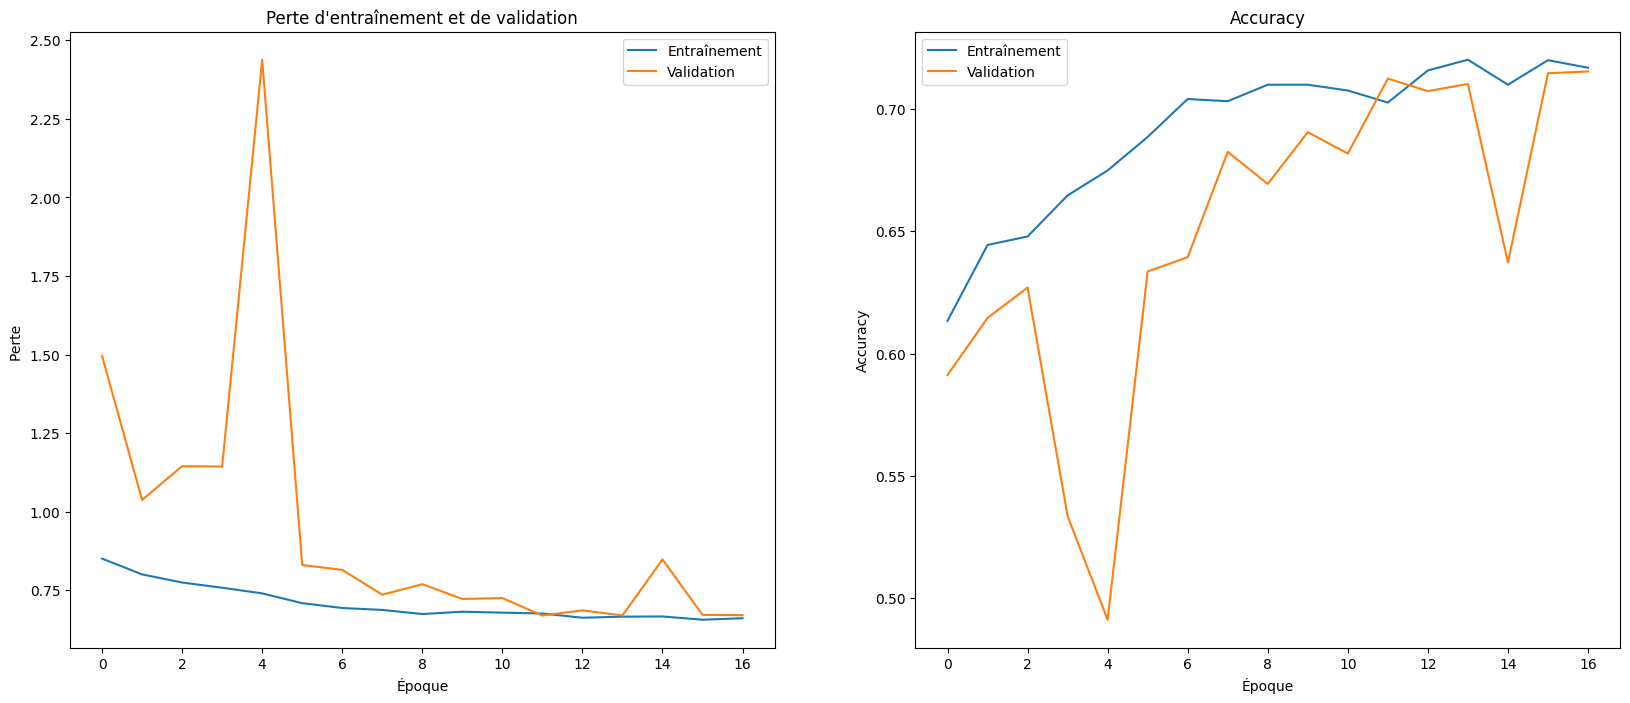

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7113 - loss: 0.6664 
Précision de validation finale: 0.7124


In [5]:
# Récupérer les données d'entraînement et de validation
train_loss = model_history.history["loss"]
val_loss = model_history.history["val_loss"]
train_accuracy =  model_history.history["accuracy"]
val_accuracy = model_history.history["val_accuracy"]

plt.figure(figsize=(20, 8))

# Tracer la perte
plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title("Perte d'entraînement et de validation")
plt.ylabel('Perte ')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='best')

# Tracer l'erreur absolue moyenne (MAE)
plt.subplot(122)
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='best')

plt.show()

# Évaluation finale sur l'ensemble de validation
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Précision de validation finale: {val_accuracy:.4f}")

2025-03-13 20:18:25.044613: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


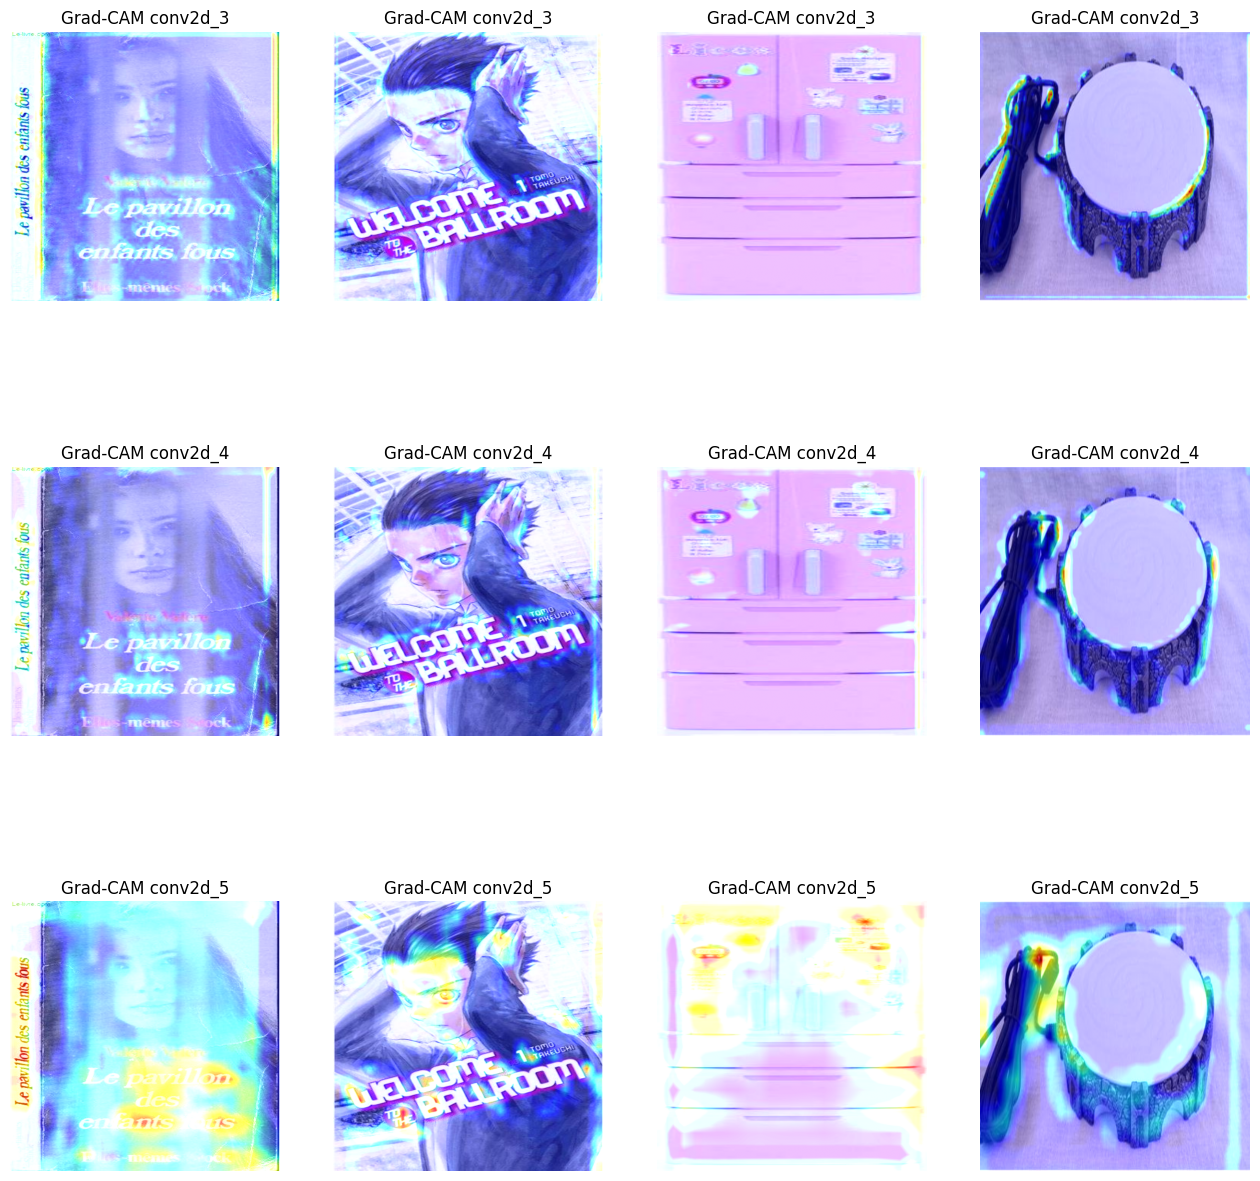

In [8]:
import numpy as np 

X = np.array([img.numpy() for img, _ in val_ds.take(1)][0]).astype(np.uint8)
y = np.array([label.numpy() for _, label in val_ds.take(1)][0])

# Sélection des images spécifiques
images = X[:4]
labels = y[:4]

def grad_cam(image, model, layer_name):
    # Récupérer la couche convolutive
    layer = model.get_layer(layer_name)
    
    # Créer un modèle qui génère les sorties de la couche convolutive et les prédictions
    grad_model = Model(inputs=model.input, outputs=[layer.output, model.output])

    # Ajout d'une dimension de batch
    image = tf.expand_dims(image, axis=0)

    # Calcul des gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        predicted_class = tf.argmax(predictions[0])  # Classe prédite
        loss = predictions[:, predicted_class]  # Perte pour la classe prédite

    # Gradients des scores par rapport aux sorties de la couche convolutive
    grads = tape.gradient(loss, conv_outputs)

    # Moyenne pondérée des gradients pour chaque canal
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Pondération des activations par les gradients calculés
    conv_outputs = conv_outputs[0]  # Supprimer la dimension batch
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalisation de la carte de chaleur
    heatmap = tf.maximum(heatmap, 0)  # Se concentrer uniquement sur les valeurs positives
    heatmap /= tf.math.reduce_max(heatmap)  # Normaliser entre 0 et 1
    heatmap = heatmap.numpy()  # Convertir en tableau numpy pour la visualisation

   # Redimensionner la carte de chaleur pour correspondre à la taille de l'image d'origine
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (image.shape[1], image.shape[2])).numpy()
    heatmap_resized = np.squeeze(heatmap_resized, axis=-1) # supprimer la dimension de taille 1 à la fin du tableau heatmap_resized

    # Colorier la carte de chaleur avec une palette (par exemple, "jet")
    heatmap_colored = plt.cm.jet(heatmap_resized)[..., :3] # Récupérer les canaux R, G, B 

    superimposed_image = heatmap_colored * 0.7 + image[0].numpy() / 255.0

    return np.clip(superimposed_image, 0, 1), predicted_class

def show_grad_cam_cnn(images, model):
    number_of_images = images.shape[0]
    conv_layers = [layer.name for layer in model.layers if isinstance(layer, Conv2D)]

    plt.figure(figsize=(16,16))

    for j, layer in enumerate(conv_layers):

        for i in range(number_of_images):

            subplot_index = i + 1 + j * number_of_images
            plt.subplot(len(conv_layers), number_of_images, subplot_index)

            # Obtenir l'image avec la carte de chaleur superposée
            grad_cam_image, predicted_class = grad_cam(images[i], model, layer)
            
            # Afficher l'image avec Grad-CAM
            plt.title(f'Grad-CAM {layer}')
            plt.imshow(grad_cam_image)
            plt.axis("off")

    plt.show()

show_grad_cam_cnn(images, model)

Found 6851 files belonging to 3 classes.


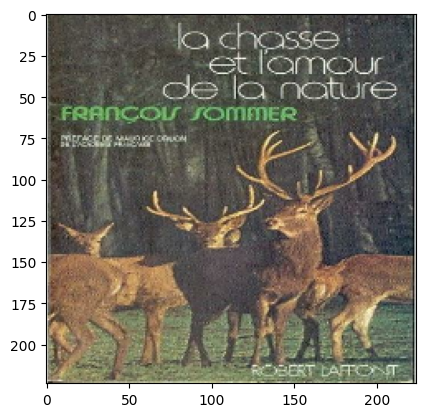

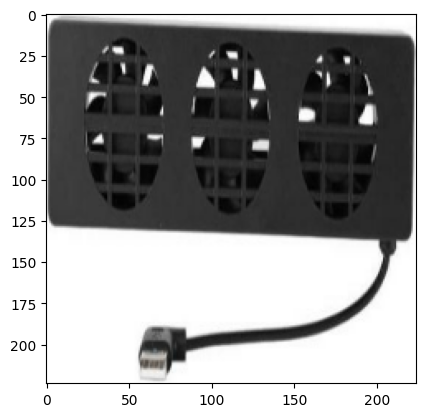

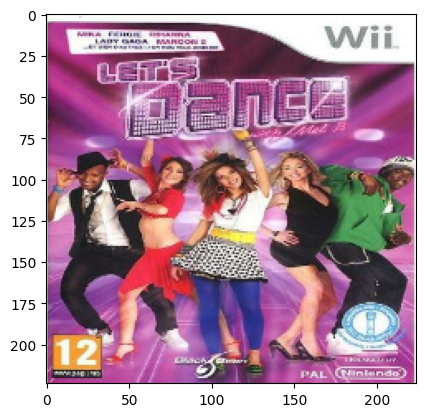

In [42]:
import tensorflow as tf
import matplotlib.pyplot as plt
# Chargement et prétraitement des images
img_size = (224, 224)  # Taille cible
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample",
    image_size=img_size,
    batch_size=batch_size
)

# Charger une image de train_ds
for images, labels in train_ds.take(1):  # Prendre un lot d'images et de labels
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.show()
    plt.imshow(images[1].numpy().astype("uint8"))
    plt.show()
    plt.imshow(images[3].numpy().astype("uint8"))
    plt.show()
